### Import Libraries and Load Data


In [1]:
# intall needed libraries
# !pip install -U pandas-profiling
# !pip install category_encoders


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import category_encoders as ce
import pandas_profiling
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import math

In [3]:
# load NY Apartment Prices Data
df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/nyc/nyc-rent-2016.csv')
assert df.shape == (48300, 34)

In [4]:
# visualize and explore the data
profile = df.profile_report()
profile

In [5]:
# clean data --> to_datetime on 'created'
df['created'] = pd.to_datetime(df['created'], infer_datetime_format=True)
df['created'].head()

0   2016-06-24 07:54:24
1   2016-06-12 12:19:27
2   2016-04-17 03:26:41
3   2016-04-18 02:22:02
4   2016-04-28 01:32:41
Name: created, dtype: datetime64[ns]

### Feature Engineering

In [6]:
print(df.columns)

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'exclusive', 'terrace', 'loft',
       'garden_patio', 'common_outdoor_space', 'wheelchair_access'],
      dtype='object')


In [7]:
# combine cats allowed and dogs allowed into pets allowed
df['pets_allowed'] = np.where((df['cats_allowed'] == 1) & (df['dogs_allowed'] == 1), 1, 0)

# remove blank spaces from entries with no description and create a no description feature
df['description'] = df['description'].str.strip().fillna('')
df['no_description'] = np.where((df['description'].str.len() < 1), 1, 0)

# create a premium feature that adds the high end ammenities 
premium_ammenities = [
    'doorman',
    'fitness_center',
    'laundry_in_unit',
    'swimming_pool',
    'hardwood_floors'
]

df['premium'] = df[premium_ammenities].sum(axis=1)

# add outdoor ammenities feature
outdoor_ammenities = [
    'roof_deck',
    'outdoor_space',
    'terrace',
    'garden_patio'
]

df['outdoors'] = df[outdoor_ammenities].sum(axis=1)

# apartment size
num_rooms = [
    'bedrooms',
    'bathrooms',
    'dining_room'
]

df['rooms'] = df[num_rooms].sum(axis=1)

### Split data into train and test

In [8]:
# train = April and May 2016
# test = June 2016
df['month'] = df['created'].dt.month

train = df[df['month'] < 6]
test = df[df['month'] == 6]

train.shape, test.shape

((31515, 40), (16785, 40))

### Create a baseline model

In [9]:
# baseline prediction = mean price
train['price'].mean()

3432.7534190068222

In [10]:
# create variables for actual and predicted prices
y_test = test['price']
y_pred = [train['price'].mean()]*len(y_test)

In [11]:
# print out mean absolute error, R^2, and root mean_squared_error
baseline_mae = mean_absolute_error(y_test, y_pred)
baseline_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
baseline_R2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {baseline_mae}')
print(f'Root Mean Squared Error: {baseline_rmse}')
print(f'R^2: {baseline_R2}')

Mean Absolute Error: 1052.6798017842948
Root Mean Squared Error: 1407.0272053329095
R^2: -0.00012859737569526075


### Create a Multiple Regression Model

In [12]:
model = LinearRegression()

In [13]:
# create feautres list
df.columns

Index(['bathrooms', 'bedrooms', 'created', 'description', 'display_address',
       'latitude', 'longitude', 'price', 'street_address', 'interest_level',
       'elevator', 'cats_allowed', 'hardwood_floors', 'dogs_allowed',
       'doorman', 'dishwasher', 'no_fee', 'laundry_in_building',
       'fitness_center', 'pre-war', 'laundry_in_unit', 'roof_deck',
       'outdoor_space', 'dining_room', 'high_speed_internet', 'balcony',
       'swimming_pool', 'new_construction', 'exclusive', 'terrace', 'loft',
       'garden_patio', 'common_outdoor_space', 'wheelchair_access',
       'pets_allowed', 'no_description', 'premium', 'outdoors', 'rooms',
       'month'],
      dtype='object')

In [14]:
features = [
    'bedrooms',
    'bathrooms',
    'latitude',
    'longitude',
    'pets_allowed',
    'premium', 
    'outdoors',
    'no_description',
    'no_fee',
    'new_construction',
    'pre-war',
    'dishwasher',
    'high_speed_internet'
]
target = 'price'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape

((31515, 13), (31515,))

In [15]:
# fit X_train and y_train to the model
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
# predict price using multiple features
y_pred = model.predict(X_test)
y_pred

array([3846.63623231, 4060.50086238, 2311.88605877, ..., 3068.55702549,
       3452.31586405, 3558.44730926])

In [17]:
mean_absolute_error(y_test, y_pred)

637.3846630336385

### Use one-hot encoding on categorical variables

In [18]:
# one-hot encoding
train.describe(exclude='number')

created description display_address        street_address  \
count                 31515       31515           31447                 31509   
unique                31116       25457            6492                 11247   
top     2016-05-02 03:41:36                    Broadway  505 West 37th Street   
freq                      3        2020             268                   120   
first   2016-04-01 22:12:41         NaN             NaN                   NaN   
last    2016-05-31 23:10:48         NaN             NaN                   NaN   

       interest_level  
count           31515  
unique              3  
top               low  
freq            21613  
first             NaN  
last              NaN

In [19]:
train['interest_level'].describe()

count     31515
unique        3
top         low
freq      21613
Name: interest_level, dtype: object

In [20]:
train['interest_level'].head()

2      high
3       low
4       low
5    medium
6       low
Name: interest_level, dtype: object

In [21]:
# use StandardScaler and OneHotEncoding then predict price
features = [
    'bedrooms',
    'bathrooms',
    'latitude',
    'longitude',
    'pets_allowed',
    'premium', 
    'outdoors',
    'no_description',
    'no_fee',
    'new_construction',
    'pre-war',
    'dishwasher',
    'high_speed_internet'
]
target = 'price'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [22]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [24]:
# print out mean absolute error, coefficients and intercept

multi_mae = mean_absolute_error(y_test, y_pred)
multi_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
multi_r2 = r2_score(y_test, y_pred)

print(f"MAE: {multi_mae}")
print(f"RMSE: {multi_rmse}")
print(f"R2: {multi_r2}\n")

print("Variable coefficients")
print('-'*25)
for i in range(len(features)):
  print(f"{features[i]}: {model.coef_[i]}")
  
print(f"\nIntercept: {model.intercept_}")

MAE: 637.3846630336625
RMSE: 894.2167859340449
R2: 0.5960417406817953

Variable coefficients
-------------------------
bedrooms: 525.7008879544082
bathrooms: 568.5410952875789
latitude: 39.03691030592478
longitude: -402.25988373153905
pets_allowed: 62.92189212622104
premium: 292.9631732092392
outdoors: -30.871545694080297
no_description: 92.59285644648293
no_fee: -66.36072264535753
new_construction: -38.976828379887
pre-war: -23.512649922151077
dishwasher: 12.370458952021806
high_speed_internet: -80.73173261859407

Intercept: 3432.753419006936


### Compare RMSE, MAE and R^2 of the models

In [25]:
# compare all models
print('Baseline Metrics:')
print(f'MAE: {baseline_mae}\nRMSE: {baseline_rmse}\nR2: {baseline_R2}')
print('-'*25)
print('Multiple Regression Metrics:')
print(f'MAE: {multi_mae}\nRMSE: {multi_rmse}\nR2: {multi_r2}')
print('-'*25)

Baseline Metrics:
MAE: 1052.6798017842948
RMSE: 1407.0272053329095
R2: -0.00012859737569526075
-------------------------
Multiple Regression Metrics:
MAE: 637.3846630336625
RMSE: 894.2167859340449
R2: 0.5960417406817953
-------------------------


### Second Multiple Regression Model with all of the new features engineered above

In [26]:
# use StandardScaler and OneHotEncoding then predict price
features = [
    'bathrooms', 
    'bedrooms',
    'latitude', 
    'longitude', 
    'pets_allowed',
    'interest_level',
    'no_fee',
    'high_speed_internet',
    'new_construction', 
    'exclusive',
    'loft',
    'wheelchair_access',
    'premium',
    'outdoors',
    'no_description',
    'pre-war',
    'laundry_in_building',
    'dining_room',
    'common_outdoor_space'
   ]
target = 'price'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [27]:
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [28]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [30]:
# print out mean absolute error, coefficients and intercept

multi_mae = mean_absolute_error(y_test, y_pred)
multi_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
multi_r2 = r2_score(y_test, y_pred)

print(f"MAE: {multi_mae}")
print(f"RMSE: {multi_rmse}")
print(f"R2: {multi_r2}\n")

print("Variable coefficients")
print('-'*25)
for i in range(len(features)):
  print(f"{features[i]}: {model.coef_[i]}")
  
print(f"\nIntercept: {model.intercept_}")

MAE: 607.9662600079145
RMSE: 856.6046790543741
R2: 0.6293092571088885

Variable coefficients
-------------------------
bathrooms: 538.3365230129596
bedrooms: 541.4794100462135
latitude: 24.721543091411586
longitude: -386.65033531576864
pets_allowed: 50.94480134610758
interest_level: -1400843807881726.8
no_fee: -2405297117412077.0
high_speed_internet: -2196388878980906.8
new_construction: -36.535363808876944
exclusive: -76.71024267783346
loft: -43.13633793864076
wheelchair_access: 26.371499229442104
premium: -0.33876499430758
outdoors: 14.565618523527583
no_description: 279.74931635330563
pre-war: -16.986688283661586
laundry_in_building: 57.698009388211084
dining_room: -36.904286729690696
common_outdoor_space: 2.046045398861896

Intercept: 3432.583005678321


### Plot Prices and Predicted Prices for a simple Linear Regression model using just Bedrooms and Bathrooms

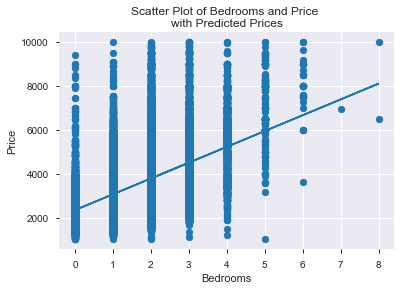

In [31]:
# plot of price and bedrooms with predicted price
feature = ['bedrooms']
target = 'price'

X = df[feature]
y = df[target]

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

plt.scatter(X, y)
plt.plot(X, y_pred)
plt.title('Scatter Plot of Bedrooms and Price \nwith Predicted Prices')
plt.xlabel('Bedrooms')
plt.ylabel('Price');

## Visualize hyperplane of best fit in 3D

In [32]:
# https://stackoverflow.com/a/47230966
# Plotly notebook mode with google colaboratory
# You need to define this function
# And call it in each offline plotting cell

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [33]:
import itertools
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

def viz3D(fitted_model, X, features, target='', num=100):
    """
    Visualize model predictions in 3D, for regression model fit on 2 features
    
    Parameters
    ----------
    fitted_model : scikit-learn model, already fitted
    X : pandas dataframe, which was used to fit model
    features : list of strings, column names of the 2 features
    target : string, name of target
    num : int, number of grid points for each feature
    
    References
    ----------
    https://plot.ly/python/3d-charts/
    """
    feature1, feature2 = features
    min1, max1 = X[feature1].min(), X[feature1].max()
    min2, max2 = X[feature2].min(), X[feature2].max()
    x1 = np.linspace(min1, max1, num)
    x2 = np.linspace(min2, max2, num)
    combos = list(itertools.product(x1, x2))
    Z = fitted_model.predict(combos).reshape(num, num)
    
    configure_plotly_browser_state()
    data = [go.Surface(x=x1, y=x2, z=Z)]
    layout = go.Layout(
        scene={'xaxis': {'title': feature1, 'range': [min1,max1], 'showticklabels': True}, 
               'yaxis': {'title': feature2, 'range': [min2,max2], 'showticklabels': True}, 
               'zaxis': {'title': target, 'showticklabels': True}}, 
    )
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [34]:
# Multiple Regression model with Bedrooms and Bathrooms for 3D visualization
model = LinearRegression()
features = [
    'bedrooms', 
    'bathrooms'
]

target = 'price'

X = df[features]
y = df[target]

model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
pd.Series(model.coef_, features)

bedrooms      417.714352
bathrooms    1523.033831
dtype: float64

In [36]:
viz3D(model, X, features, target)

## Visualizing Geographical Data

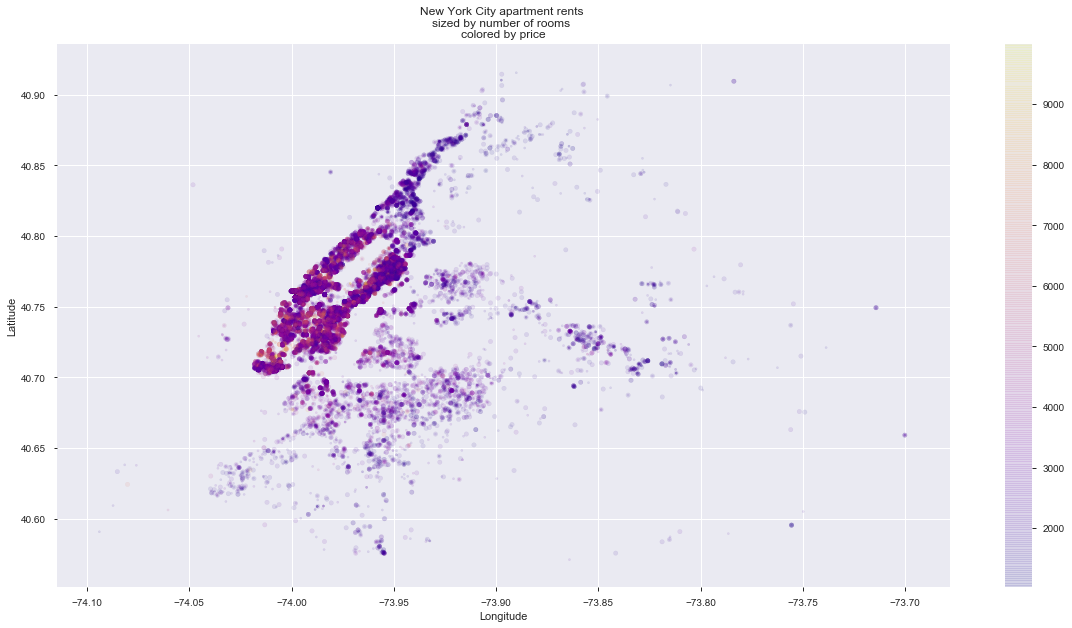

In [37]:
plt.figure(figsize=(20,10))
scatter = plt.scatter(
    x=df['longitude'], y=df['latitude'], 
    alpha=0.1, s=df['rooms']**2, sizes=(5,20), 
    c=df['price'], cmap=plt.get_cmap("plasma")
)
plt.colorbar(scatter)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('New York City apartment rents \nsized by number of rooms \ncolored by price');

In [38]:
import folium

In [42]:
lon = df['longitude'].tolist()
lat = df['latitude'].tolist()
size = df['price'].tolist()

In [80]:
m = folium.Map(
        location=[40.75, -73.9],
        tiles = "Stamen Terrain",
        zoom_start=11
)

for i in range(1500):
    folium.CircleMarker(
        location=[lat[i], lon[i]],
        radius=size[i]/1000,
        popup=size[i],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(m)

m

In [81]:
m.save('ny_test.html')